In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc

In [75]:
submit=pd.read_csv("sample_submission.csv")
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")

In [76]:
train_data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [77]:
test_data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [78]:
test_data.shape,train_data.shape

((125690, 12), (188533, 13))

In [79]:
train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

In [80]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [81]:
test_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         125690 non-null  object
 1   model         125690 non-null  object
 2   model_year    125690 non-null  int64 
 3   milage        125690 non-null  int64 
 4   fuel_type     122307 non-null  object
 5   engine        125690 non-null  object
 6   transmission  125690 non-null  object
 7   ext_col       125690 non-null  object
 8   int_col       125690 non-null  object
 9   accident      124058 non-null  object
 10  clean_title   111451 non-null  object
dtypes: int64(2), object(9)
memory usage: 10.5+ MB


In [82]:
train_data.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [83]:
test_data.isnull().sum()


brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

In [84]:
train_data.columns


Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [85]:
cat_col = train_data.select_dtypes(include=['object']).columns
s_val = {col: train_data[col].nunique() for col in cat_col}
for col, unique_ones in s_val.items():
    print(f"{col}: {unique_ones} unique values")

gc.collect()

brand: 57 unique values
model: 1897 unique values
fuel_type: 7 unique values
engine: 1117 unique values
transmission: 52 unique values
ext_col: 319 unique values
int_col: 156 unique values
accident: 2 unique values
clean_title: 1 unique values


71510

In [86]:
cat_col = test_data.select_dtypes(include=['object']).columns
s_val = {col: test_data[col].nunique() for col in cat_col}
for col, unique_ones in s_val.items():
    print(f"{col}: {unique_ones} unique values")

gc.collect()


brand: 55 unique values
model: 1891 unique values
fuel_type: 7 unique values
engine: 1117 unique values
transmission: 52 unique values
ext_col: 317 unique values
int_col: 156 unique values
accident: 2 unique values
clean_title: 1 unique values


0

In [87]:
test_data.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'],
      dtype='object')

In [88]:
train_data.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [89]:
import seaborn as sns

In [90]:
missing_train = train_data.isna().mean() * 100
missing_test = test_data.isna().mean() * 100

print(missing_train[missing_train > 0])

print(missing_test[missing_test > 0])

fuel_type       2.696080
accident        1.300568
clean_title    11.360876
dtype: float64
fuel_type       2.691543
accident        1.298433
clean_title    11.328666
dtype: float64


In [91]:
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

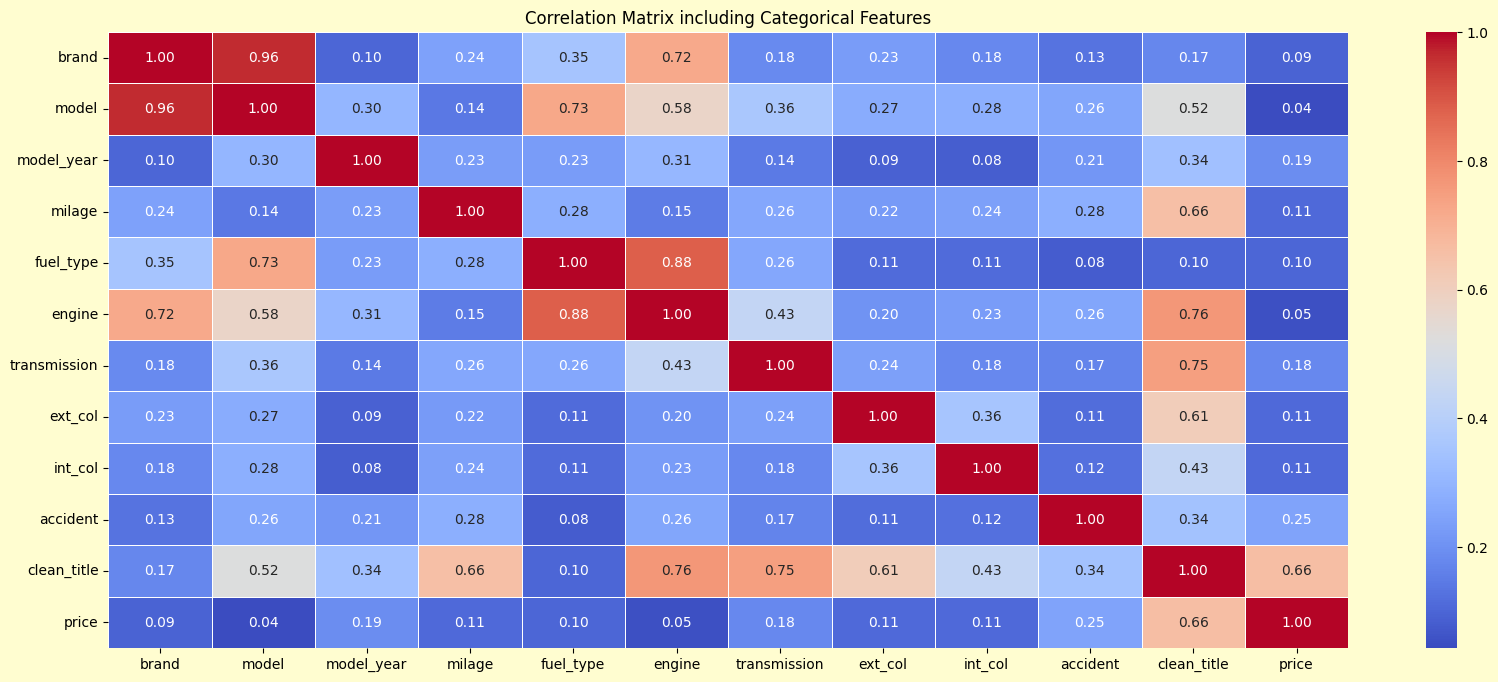

In [92]:
from dython.nominal import associations

associations_df = associations(train_data, nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0')
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

In [93]:
train_data.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [94]:
from sklearn.impute import KNNImputer

def knn_impute(df, n_neighbors=5):
    enc = df.copy()
    for col in enc.select_dtypes(include='object').columns:
        enc[col] = enc[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed = pd.DataFrame(knn_imputer.fit_transform(enc), columns=enc.columns)
    for col in df.select_dtypes(include='object').columns:
        imputed[col] = imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return imputed


In [95]:
train_imputed = knn_impute(train_data, n_neighbors=25)
test_imputed = knn_impute(test_data, n_neighbors=25)

In [96]:
cat_cols_train = train_imputed.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(train_imputed[cat_cols_train].astype(str))
test_imputed[cat_cols_train] = ordinal_encoder.transform(test_imputed[cat_cols_train].astype(str))

In [97]:
train_imputed.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,0.0,4200.0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0


In [98]:
test_imputed.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,26.0,1390.0,2015.0,98000.0,2.0,325.0,16.0,304.0,10.0,1.0,0.0
1,26.0,1377.0,2020.0,9142.0,3.0,787.0,31.0,263.0,14.0,1.0,0.0
2,14.0,636.0,2022.0,28121.0,2.0,540.0,3.0,304.0,57.0,1.0,1.0
3,3.0,182.0,2016.0,61258.0,2.0,192.0,39.0,261.0,14.0,1.0,1.0
4,3.0,181.0,2018.0,59000.0,2.0,364.0,38.0,128.0,14.0,1.0,0.0


In [99]:
train_data = train_imputed
test_data = test_imputed

In [100]:
train_data['engine_transmission'] = train_data['engine'] * train_data['transmission']
test_data['engine_transmission'] = test_data['engine'] * test_data['transmission']

In [101]:
train_data.isnull().sum()

brand                  0
model                  0
model_year             0
milage                 0
fuel_type              0
engine                 0
transmission           0
ext_col                0
int_col                0
accident               0
clean_title            0
price                  0
engine_transmission    0
dtype: int64

In [102]:
current_year = 2024
luxury_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Lexus', 'Tesla']


def create_features(df):
    df['rare_fuel_type'] = df['fuel_type'].apply(lambda x: 0 if x in ['Petrol', 'Diesel'] else 1)
    df['is_automatic'] = df['transmission'].apply(lambda x: 1 if x == 'Automatic' else 0)
    df['has_accident_history'] = df['accident'].apply(lambda x: 1 if x != 'Unknown' and x != 'None' else 0)
    df['color_match'] = df.apply(lambda row: 1 if row['ext_col'] == row['int_col'] else 0, axis=1)
    df['is_luxury_brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    return df

In [103]:
train_data.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,engine_transmission
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,0.0,4200.0,4408.0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0,13908.0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0,24320.0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0,42287.0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0,5957.0


In [104]:
test_data.shape,train_data.shape

((125690, 12), (188533, 13))

In [105]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_out

df_train_no_outliers = remove_outliers_iqr(train_data, 'milage')
df_train_no_outliers = remove_outliers_iqr(df_train_no_outliers, 'price')
df_train_no_outliers.reset_index(drop=True, inplace=True)

In [106]:
train_data

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,engine_transmission
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,0.0,4200.0,4408.0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0,13908.0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0,24320.0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0,42287.0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0,5957.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,8.0,604.0,2017.0,49000.0,2.0,866.0,49.0,304.0,10.0,1.0,0.0,27500.0,42434.0
188529,36.0,206.0,2018.0,28600.0,2.0,770.0,31.0,304.0,14.0,0.0,0.0,30000.0,23870.0
188530,36.0,223.0,2021.0,13650.0,2.0,921.0,23.0,304.0,14.0,1.0,0.0,86900.0,21183.0
188531,3.0,1471.0,2022.0,13895.0,2.0,512.0,1.0,82.0,14.0,1.0,1.0,84900.0,512.0


In [107]:
df_train_no_outliers.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,engine_transmission
0,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0,13908.0
1,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0,24320.0
2,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0,42287.0
3,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0,5957.0
4,3.0,182.0,2018.0,40950.0,2.0,364.0,38.0,304.0,155.0,1.0,0.0,29950.0,13832.0


In [108]:
df_train_no_outliers.isnull().sum()

brand                  0
model                  0
model_year             0
milage                 0
fuel_type              0
engine                 0
transmission           0
ext_col                0
int_col                0
accident               0
clean_title            0
price                  0
engine_transmission    0
dtype: int64

In [109]:
df_train_no_outliers.isnull().sum()

brand                  0
model                  0
model_year             0
milage                 0
fuel_type              0
engine                 0
transmission           0
ext_col                0
int_col                0
accident               0
clean_title            0
price                  0
engine_transmission    0
dtype: int64

In [110]:
df_train_no_outliers.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,engine_transmission
0,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0,13908.0
1,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0,24320.0
2,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0,42287.0
3,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0,5957.0
4,3.0,182.0,2018.0,40950.0,2.0,364.0,38.0,304.0,155.0,1.0,0.0,29950.0,13832.0


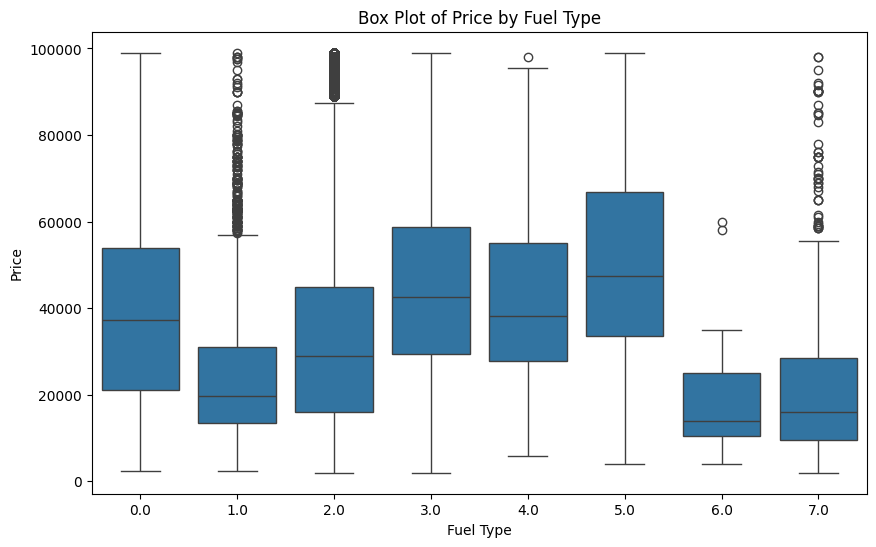

In [111]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel_type', y='price', data=df_train_no_outliers)
plt.title('Box Plot of Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()

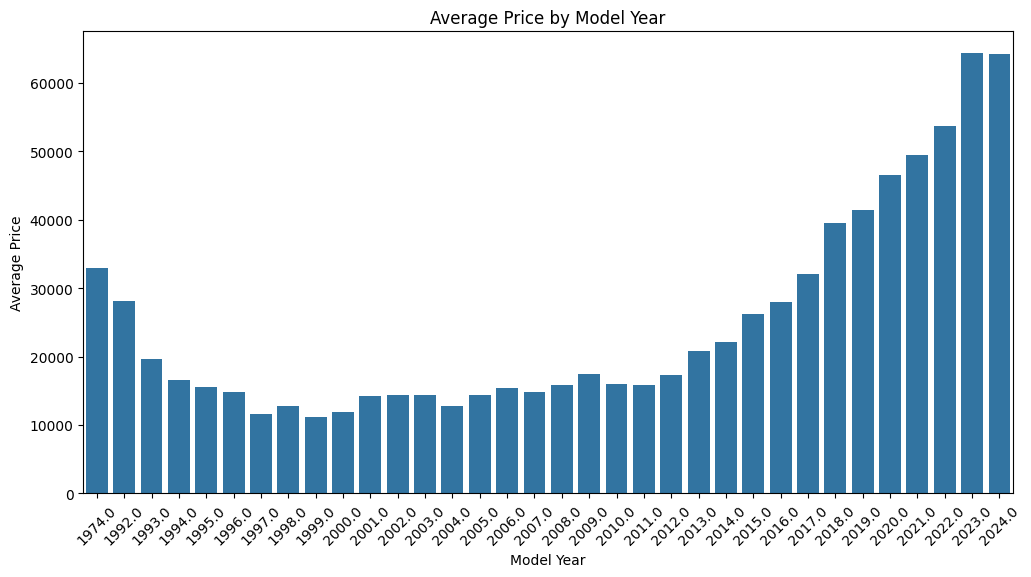

In [112]:
plt.figure(figsize=(12, 6))
sns.barplot(x='model_year', y='price', data=df_train_no_outliers, errorbar=None)
plt.title('Average Price by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

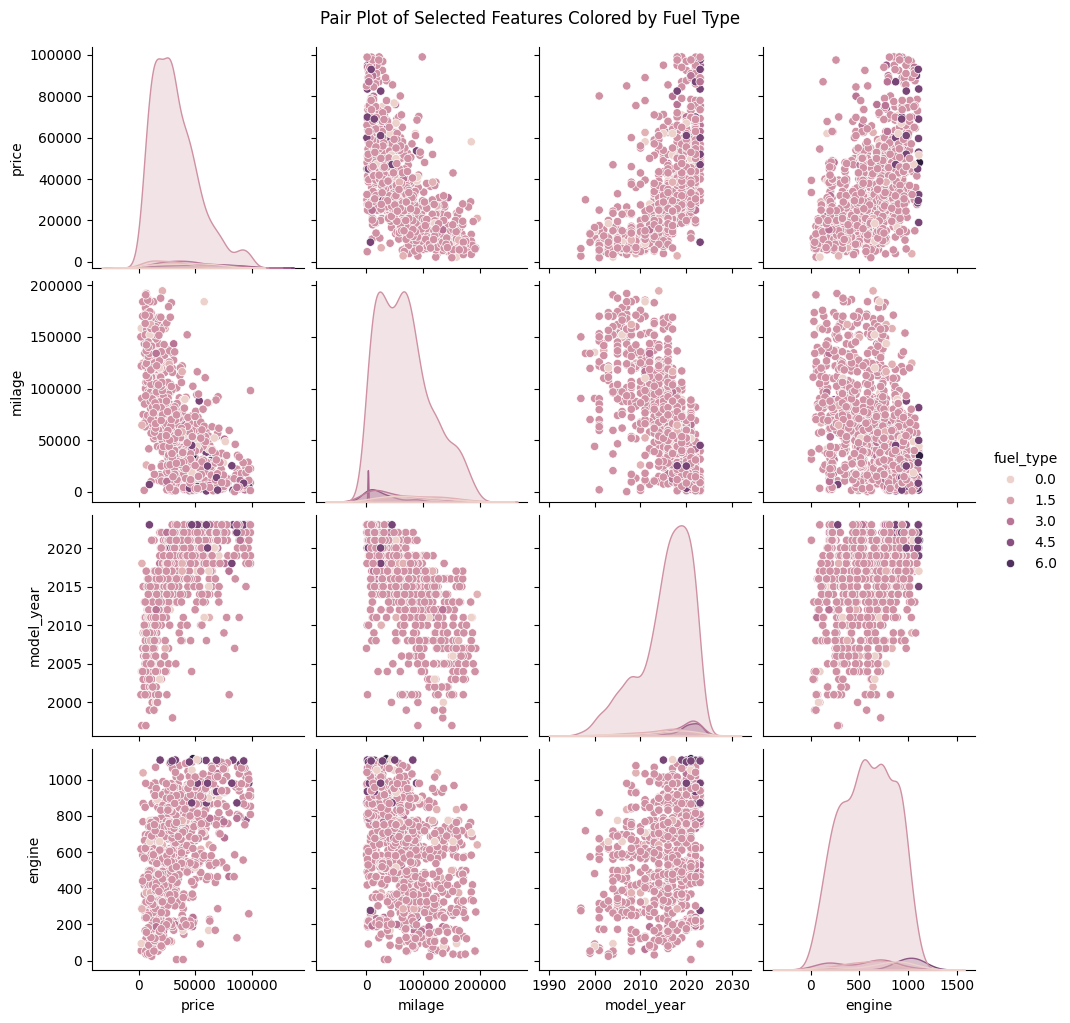

In [113]:
x = df_train_no_outliers[:1000]
sns.pairplot(x[['price', 'milage', 'model_year', 'engine', 'fuel_type']], hue='fuel_type')
plt.suptitle('Pair Plot of Selected Features Colored by Fuel Type', y=1.02)
plt.show()

In [114]:
y = train_data['price']
X = train_data.drop(['price'], axis=1)

In [115]:
train_data.shape

(188533, 13)

In [116]:
train_data.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'engine_transmission'],
      dtype='object')

In [117]:
test_data.shape

(125690, 12)

In [118]:
test_data.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'engine_transmission'],
      dtype='object')

In [119]:
train_data.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,engine_transmission
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,0.0,4200.0,4408.0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0,13908.0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0,24320.0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0,42287.0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0,5957.0


In [120]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(X)
scaled_test_data = scaler.transform(test_data)

In [121]:
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

lgb_params={
                'num_leaves': 426,
                 'max_depth': 20,
                 'learning_rate': 0.011353178352988012,
                 'n_estimators': 10000,
                 'metric': 'rmse',
                 'subsample': 0.5772552201954328,
                 'colsample_bytree': 0.9164865430101521,
                 'reg_alpha': 1.48699088003429e-06,
                 'reg_lambda': 0.41539458543414265,
                 'min_data_in_leaf': 73,
                 'feature_fraction': 0.751673655170548,
                 'bagging_fraction': 0.5120415391590843,
                 'bagging_freq': 2,
                 'random_state': 42,
                 'min_child_weight': 0.017236362383443497,
                 'cat_smooth': 54.81317407769262,
                 'verbose' : -1,
                 'early_stopping_rounds': 200,
}


lgbm_predictions = np.zeros(len(scaled_train_data))
lgbm_true_labels = np.zeros(len(scaled_train_data))
lgbm_test_predictions = np.zeros(len(scaled_test_data))


for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")

    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgbm_model = LGBMRegressor(**lgb_params)

    lgbm_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='rmse',
                   #early_stopping_rounds=10,
                   #verbose=False
                  )


    lgbm_fold_preds = lgbm_model.predict(X_val)
    lgbm_fold_test_preds = lgbm_model.predict(scaled_test_data)

    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits
    fold_rmse = np.sqrt(mean_squared_error(y_val, lgbm_fold_preds))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_lgbm = np.sqrt(mean_squared_error(lgbm_true_labels, lgbm_predictions))
print(f"Overall RMSE (LGBMRegressor): {overall_rmse_lgbm:.4f}")

Training fold 1/3...


C:\Users\User\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 1 RMSE: 66550.5811
Training fold 2/3...


C:\Users\User\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 2 RMSE: 75185.9441
Training fold 3/3...


C:\Users\User\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\User\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 3 RMSE: 76092.8975
Overall RMSE (LGBMRegressor): 72737.0181


In [67]:
xgb_params={
     'lambda': 0.03880258557285165,
     'alpha': 0.02129832295514386,
     'colsample_bytree': 0.4,
     'subsample': 0.7,
     'learning_rate': 0.014,
     'max_depth': 17,
     'random_state': 2020,
     'min_child_weight': 85,
     'n_estimators': 10000,
     'early_stopping_rounds': 200,
     'eval_metric': 'rmse'

}

n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

xgb_predictions = np.zeros(len(scaled_train_data))
xgb_true_labels = np.zeros(len(scaled_train_data))
xgb_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")

    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)

    xgb_fold_preds = xgb_model.predict(X_val)
    xgb_fold_test_preds = xgb_model.predict(scaled_test_data)
    xgb_predictions[val_idx] = xgb_fold_preds
    xgb_true_labels[val_idx] = y_val
    xgb_test_predictions += xgb_fold_test_preds / n_splits

    fold_rmse = np.sqrt(mean_squared_error(y_val, xgb_fold_preds))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_xgb = np.sqrt(mean_squared_error(xgb_true_labels, xgb_predictions))
print(f"Overall RMSE (XGBRegressor): {overall_rmse_xgb:.4f}")

Training fold 1/3...
Fold 1 RMSE: 66511.7788
Training fold 2/3...
Fold 2 RMSE: 75264.0073
Training fold 3/3...
Fold 3 RMSE: 76014.8713
Overall RMSE (XGBRegressor): 72724.9027


In [68]:
xgb_test_predictions

array([17293.90283203, 79646.53710938, 56712.20117188, ...,
       21053.22949219, 19309.09130859, 38334.42871094], shape=(125690,))

In [69]:
lgbm_test_predictions

array([17503.25929456, 82482.16997067, 63826.28816732, ...,
       22283.3677241 , 16361.82251807, 36184.10365716], shape=(125690,))

In [70]:
import numpy as np
from sklearn.metrics import mean_squared_error
best_rmse = float("inf")
best_w = None

for w in np.linspace(0, 1, 101):  # try weights from 0.00 to 1.00
    blended = w * xgb_predictions + (1 - w) * lgbm_predictions
    rmse = np.sqrt(mean_squared_error(y, blended))
    if rmse < best_rmse:
        best_rmse = rmse
        best_w = w

print(f"Best weight for XGB: {best_w:.2f}, for LGBM: {1-best_w:.2f}")
print(f"Best blended RMSE: {best_rmse:.4f}")


Best weight for XGB: 0.52, for LGBM: 0.48
Best blended RMSE: 72668.5928


In [71]:
submit['price'] = 0.52 * xgb_test_predictions + 0.48 * lgbm_test_predictions


In [72]:
submit.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

,id,price
0,188533,17394.393934
1,188534,81007.640883
2,188535,60126.962930
3,188536,25508.551363
4,188537,29624.579057
...,...,...
125685,314218,34537.744822
125686,314219,49322.230693
125687,314220,21643.695844
125688,314221,17894.402289
